In [1]:
import numpy as np
import os
import pandas as pd
import tools
from tqdm import tqdm
from matplotlib import pyplot as plt
import measures as ms
import seaborn as sns

from scipy.stats import ttest_rel, wilcoxon


import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from tempfile import TemporaryDirectory
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
# install Rtrack
rtrack = importr('Rtrack')
rstatix = importr('rstatix')

%load_ext autoreload
%autoreload 2

Warning message:
D-Bus service not found!

- If you are in a container environment, please consider adding the
  following to your configuration to silence this warning:

  options(bspm.sudo = TRUE)

- If you are in a desktop/server environment, please remove any 'bspm'
  installation from the user library and force a new system
  installation as follows:

  $ sudo Rscript --vanilla -e 'install.packages("bspm", repos="https://cran.r-project.org")' 


## Params

In [2]:
path_exp = "/home/jovyan/data/PNN.A-CMWMRawData/"
path_probe_trials = "PNN.A-C.MWM.probe/"
path_train_trials = ["PNN.A-C.MWM.REV.Train/",]

fname_genotypes = "MWMGenotypes.xlsx"

#radius platform in cm
r_platform = 6

# assume the water maze radius is 60 cm *** Double Check ***
r_maze = 61

## Load metadata

In [3]:
# metadata of each recording
df_info_probe = tools.load_finfo_probe(path_exp+path_probe_trials)
df_info_probe['day'] = "probe"
df_info_train = tools.load_finfo_train(path_exp+path_train_trials[0])

df_info = pd.concat([df_info_probe, df_info_train])

# genotype data for each individual
def handle_values(val):
    if isinstance(val, str) and '*' in val:
        return val.replace('*', '')  # Replace '*' with an empty string
    return val
df_genotypes = pd.read_excel(path_exp+fname_genotypes, converters={'Subj': handle_values}, usecols=[0, 1, 2])
df_genotypes.set_index('Subj', inplace=True)

# merge both
df_info = pd.merge(df_info, df_genotypes[['sex', 'Geno']], left_on='animal_id', right_index=True, how='left')
df_info.reset_index(drop=True, inplace=True)

In [4]:
# add experimental day
df_info['exp_day'] = np.nan

# 1. during HID phase
sel = ((df_info['phase'] == 'HID') & (df_info['day'] == 'probe'))
df_info.loc[sel, 'exp_day'] = 5

# 2. during Rev phase
# a) training
sel = ((df_info['phase'] == 'REV') & (df_info['day'] != 'probe'))
df_info.loc[sel, 'exp_day'] = df_info.loc[sel, 'day'].astype(int)+5

# b) probe
sel = ((df_info['phase'] == 'REV') & (df_info['day'] == 'probe'))
df_info.loc[sel, 'exp_day'] = 14

### Extract old platform location based on probe trial from initial learning.
The data does not explicitly state the location of the old platform during reversal learning.
Therefore we take the position of the non-existing platform of the probe trial.

In [5]:
idx_hid_probe = (
    (df_info['phase']=='HID') &
    (df_info['day'] == 'probe'))
df_info_hid_prob = df_info[idx_hid_probe][['animal_id', 'platform_pos']]
df_info_hid_prob.rename(columns={'platform_pos': 'xy_pltfrm_old'}, inplace=True)
df_info = df_info.merge(df_info_hid_prob, on='animal_id', how='left')

# for correctnes
df_info.loc[idx_hid_probe, 'xy_pltfrm_old'] = np.nan

In [6]:

# Enable ordering across experimental type, day and trial
ls_df_info_i = []
for i in df_info['animal_id'].unique():
    df_info_i = df_info[df_info['animal_id'] == i]
    df_info_i = df_info_i.sort_values(['Geno', 'phase', 'day', 'trial'])
    df_info_i['order'] = np.arange(len(df_info_i))
    df_info_i['grp_day_trial'] = df_info_i['phase'] + '_' + df_info_i['day'].astype(str) + '_' + df_info_i['trial'].astype(str)
    df_info_i['grp_day'] = df_info_i['phase'] + '_' + df_info_i['day'].astype(str)
    ls_df_info_i.append(df_info_i)
df_info = pd.concat(ls_df_info_i)
df_info = df_info.reset_index(drop=True)

## Estimate box boundaries based on trajectory (preferred for now)

In [7]:
bool_display = False

# points to plot
ls_pts = ['platform_pos', 'Q1', 'Q2', 'Q3', 'Q4',]

gp_pts = df_info.groupby(ls_pts)
for i, gp_i in tqdm(gp_pts):  
    ls_xy = []
    for j, row_j in gp_i.iterrows():
        # load recording
        path_j = row_j['relative_path']
        rec = tools.load_recording(path_j)
        # extract positions
        xy = np.hstack([np.array(rec['X center']), np.array(rec['Y center'])])
        ls_xy.append(xy)
    xy_all = np.vstack(ls_xy)

    # estimate center and radius based on max/min in x and y.
    center_x, center_y, radius = tools.detect_circle_boundaries(xy_all[:, 0], xy_all[:, 1])

    # apply correction factor
    #radius = radius * r_maze_corr
    radius = r_maze
    
    # store in dataframe
    df_info.loc[gp_i.index, 'center_x'] = center_x
    df_info.loc[gp_i.index, 'center_y'] = center_y
    df_info.loc[gp_i.index, 'radius'] = radius
    
    if bool_display:
        # Create a scatter plot
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.scatter(xy_all[:, 0], xy_all[:, 1], s=1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(i)
    
        # plot cirlce
        circle_wall = plt.Circle((center_x, center_y), radius, color='red', fill=False)
        ax.add_patch(circle_wall)
    
        # plot platform
        circle_pltfrm = plt.Circle(i[0], r_platform, color='red', fill=False)
        ax.add_patch(circle_pltfrm)
    
        # plot quadrant points
        for j in range(1,5):
            circle_pltfrm = plt.Circle(i[j], 1, color='orange', fill=True)
            ax.add_patch(circle_pltfrm)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(i)
        plt.legend()
        plt.grid(True)
        plt.show()


100%|███████████████████████████████████████████████████████████████████| 25/25 [03:07<00:00,  7.51s/it]


## Classify Strategy

In [8]:
fname_res = 'data/strategy/df_res.pckl'
compute=True

In [9]:
if compute:
    ls_res = []
    for i, row_i in tqdm(df_info.iterrows()):
        
        # load recording
        path_i = row_i['relative_path']
        rec = tools.load_recording(path_i)
        # extract positions
        xy = np.hstack([np.array(rec['X center']), np.array(rec['Y center'])])
        # extract trial time
        t_trial = np.array(rec['Trial time']).flatten()
        # get recording time
        t_rec = np.array(rec['Recording time']).flatten()

        # center coordinates
        xy_center = np.array([
            row_i['center_x'],
            row_i['center_y']])
        xy -= xy_center

        ## exclude nan values
        #xy, t = tls.exclude_nan_values(xy, t)

        ## interpolate xy values
        #xy, t = tls.interpolate_xy_values(xy, t, dt)

        # get current platform location
        xy_pltfrm = np.array(row_i['platform_pos'])
        
        # get old platform location
        xy_pltfrm_old = np.array(row_i['xy_pltfrm_old'])

        # transform arena and path info for rtrack
        # arena
        s_arena = (
            'time.units = s\n' +
            'type = mwm\n' +
            'trial.length = 60\n'+
            'arena.bounds = circle 0.0 0.0 ' + str(row_i['radius'])+'\n'+
            'goal = circle '+str(xy_pltfrm[0]) + ' ' + str(xy_pltfrm[1]) + ' ' + str(r_platform) + '\n')
        if np.all(~pd.isna(xy_pltfrm_old)):
            s_arena += 'old.goal = circle '+str(xy_pltfrm_old[0]) + ' ' + str(xy_pltfrm_old[1]) + ' ' + str(r_platform)

        # path
        df_tmp = pd.DataFrame({
            'Time': t_rec,
            'X': xy[:, 0],
            'Y': xy[:, 1]})

        # create temporary directory 
        with TemporaryDirectory() as temp_dir:
            #temp_dir = mkdtemp()
            # store and read arena
            fname_arena = temp_dir+'/arena.txt'
            with open(fname_arena, 'w') as f:
                f.write(s_arena)

            # read arena
            arena = rtrack.read_arena(fname_arena)

            # store path
            fname_path = temp_dir+'/path.csv'
            df_tmp.to_csv(
                fname_path,
                sep=',',
                #header=False,
                index=False)

            dct_args = {'track.format': 'raw.csv'}
            # load path
            path = rtrack.read_path(
                fname_path,
                arena,
                **dct_args)

            metrics = rtrack.calculate_metrics(path, arena)

        # define strategy
        strategy = rtrack.call_strategy(metrics)

        # convert to pandas dataframe
        dct_strat = {x: v for x, v in strategy.items()}
        with localconverter(ro.default_converter + pandas2ri.converter):
            df_strat = ro.conversion.rpy2py(dct_strat['calls'])
        assert len(df_strat) == 1

        res = {
            'strategy_idx': int(df_strat['strategy'].iloc[0]),
            'strategy_name': df_strat['name'].iloc[0],
            'strategy_confidence': df_strat['confidence'].iloc[0]}
        # get also confidences for all other strategies
        for i in range(1, 10):
            res[str(i) + '_conf'] = df_strat[str(i)].iloc[0]
        ls_res.append(res)

    df_res = pd.DataFrame(ls_res)
    df_res.to_pickle(fname_res)
else:
    df_res = pd.read_pickle(fname_res)
df_info = df_info.join(df_res)

1331it [05:53,  3.76it/s]


In [10]:
i = 20
row_i = df_info.iloc[i]

In [11]:
ls_res = []
# load recording
path_i = row_i['relative_path']
rec = tools.load_recording(path_i)
# extract positions
xy = np.hstack([np.array(rec['X center']), np.array(rec['Y center'])])
# extract trial time
t_trial = np.array(rec['Trial time']).flatten()
# get recording time
t_rec = np.array(rec['Recording time']).flatten()

# center coordinates
xy_center = np.array([
    row_i['center_x'],
    row_i['center_y']])
xy -= xy_center

## exclude nan values
#xy, t = tls.exclude_nan_values(xy, t)

## interpolate xy values
#xy, t = tls.interpolate_xy_values(xy, t, dt)

# get current platform location
xy_pltfrm = np.array(row_i['platform_pos'])

# get old platform location
xy_pltfrm_old = np.array(row_i['xy_pltfrm_old'])

# transform arena and path info for rtrack
# arena
s_arena = (
    'time.units = s \n' +
    'type = mwm\n' +
    'trial.length = 60\n'+
    'arena.bounds = circle 0.0 0.0 ' + str(row_i['radius']*0.9)+'\n'+
    'goal = circle '+str(xy_pltfrm[0]) + ' ' + str(xy_pltfrm[1]) + ' ' + str(r_platform) + '\n')
if np.all(~pd.isna(xy_pltfrm_old)):
    s_arena += 'old.goal = circle '+str(xy_pltfrm_old[0]) + ' ' + str(xy_pltfrm_old[1]) + ' ' + str(r_platform)

# path
df_tmp = pd.DataFrame({
    'Time': t_rec,
    'X': xy[:, 0],
    'Y': xy[:, 1]})

# create temporary directory 
with TemporaryDirectory() as temp_dir:
    #temp_dir = mkdtemp()
    # store and read arena
    fname_arena = temp_dir+'/arena.txt'
    with open(fname_arena, 'w') as f:
        f.write(s_arena)

    # read arena
    arena = rtrack.read_arena(fname_arena)

    # store path
    fname_path = temp_dir+'/path.csv'
    df_tmp.to_csv(
        fname_path,
        sep=',',
        #header=False,
        index=False)

    dct_args = {'track.format': 'raw.csv'}
    # load path
    path = rtrack.read_path(
        fname_path,
        arena,
        **dct_args)

    metrics = rtrack.calculate_metrics(path, arena)

# define strategy
strategy = rtrack.call_strategy(metrics)

# convert to pandas dataframe
dct_strat = {x: v for x, v in strategy.items()}
with localconverter(ro.default_converter + pandas2ri.converter):
    df_strat = ro.conversion.rpy2py(dct_strat['calls'])
assert len(df_strat) == 1

res = {
    'strategy_idx': int(df_strat['strategy'].iloc[0]),
    'strategy_name': df_strat['name'].iloc[0],
    'strategy_confidence': df_strat['confidence'].iloc[0]}
# get also confidences for all other strategies
for i in range(1, 10):
    res[str(i) + '_conf'] = df_strat[str(i)].iloc[0]
ls_res.append(res)


In [12]:
df_strat['name'].iloc[0]

'corrected path'

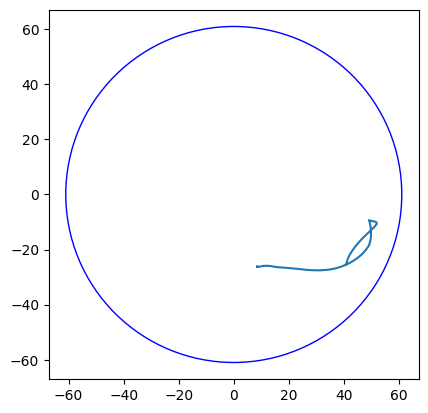

In [13]:
import matplotlib.patches as patches


fig, ax = plt.subplots(1)
ax.plot(df_tmp['X'], df_tmp['Y'])
ax.set_aspect('equal')
circle = patches.Circle((0., 0.), radius=row_i['radius'], edgecolor='blue', facecolor='none')
ax.add_patch(circle)

plt.show()

In [14]:
df_info['strategy_name'].iloc[43]

'perseverance'

In [15]:
s_arena

'time.units = s \ntype = mwm\ntrial.length = 60\narena.bounds = circle 0.0 0.0 54.9\ngoal = circle 7.45 -20.42 6\nold.goal = circle 1.53 40.33 6'

In [16]:
s_arena

'time.units = s \ntype = mwm\ntrial.length = 60\narena.bounds = circle 0.0 0.0 54.9\ngoal = circle 7.45 -20.42 6\nold.goal = circle 1.53 40.33 6'

## Plot

### Summary plot per strategy across all available trials

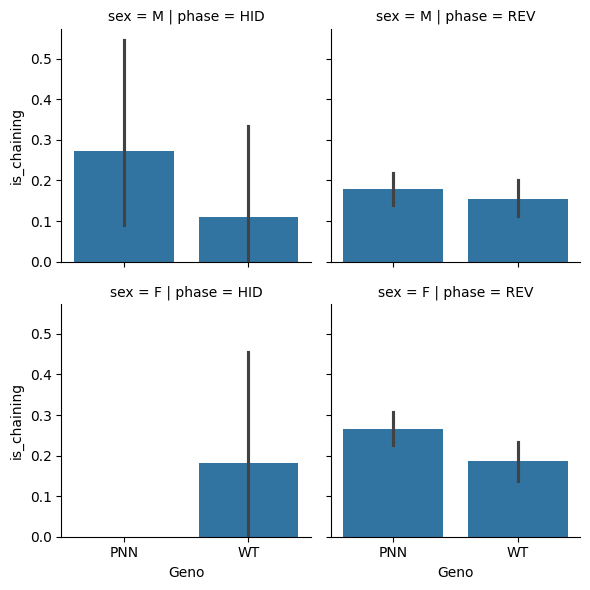

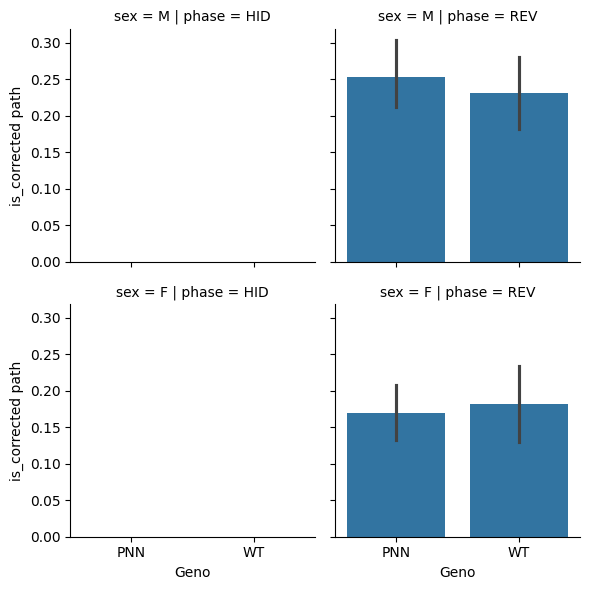

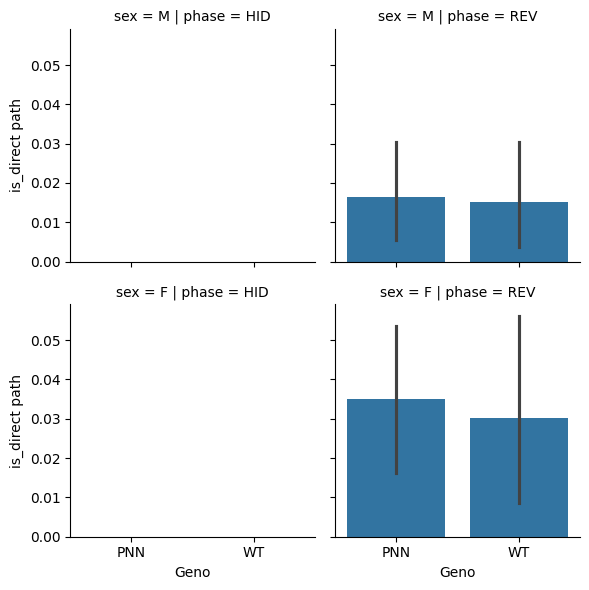

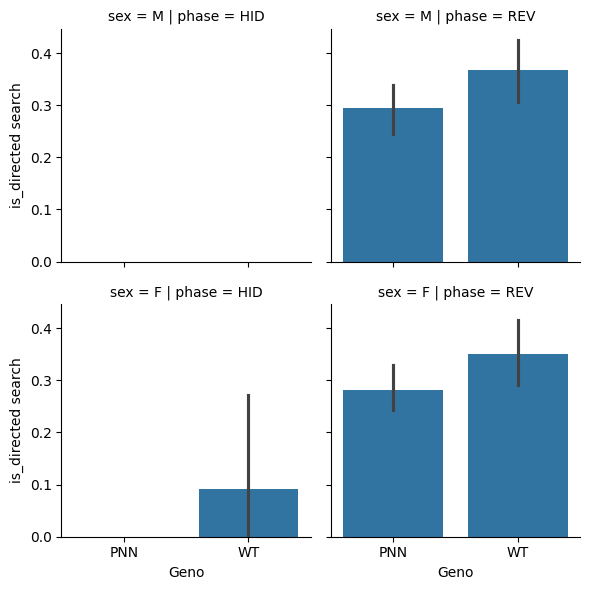

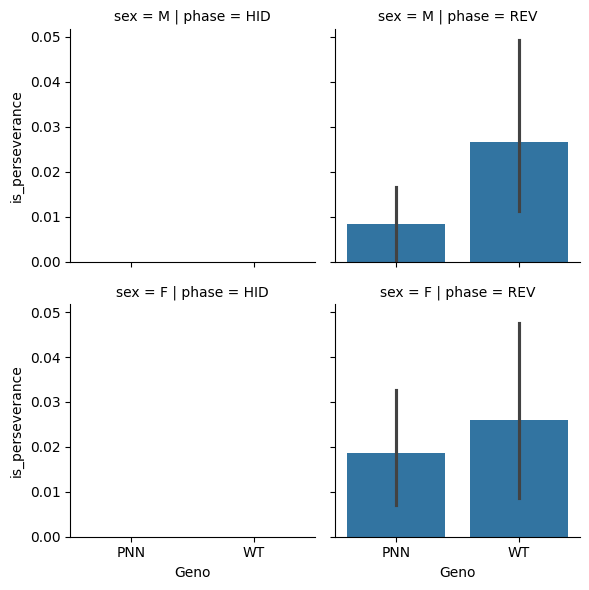

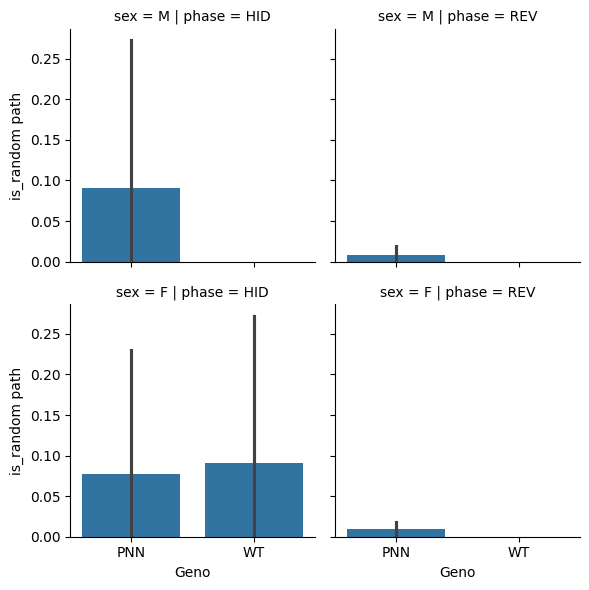

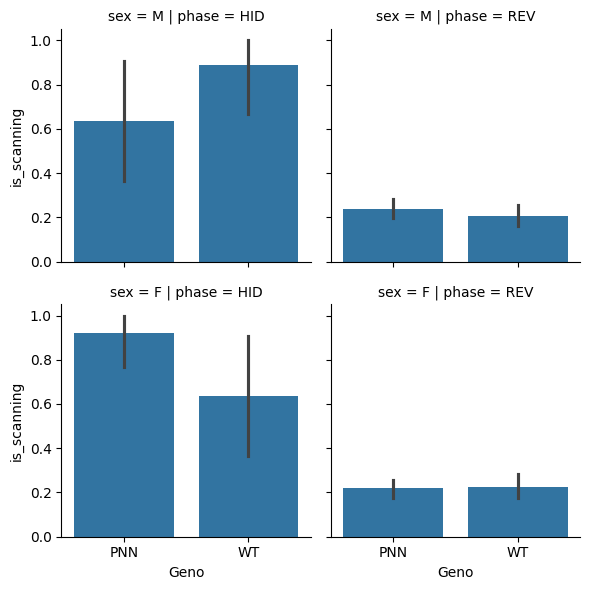

In [17]:
for strat_i in np.unique(df_info['strategy_name']):
    df_info['is_'+strat_i] = df_info['strategy_name']==strat_i

for strat_i in np.unique(df_info['strategy_name']):
    
    # Create a FacetGrid with 'phase' as the column variable and 'sex' as the row variable
    g = sns.FacetGrid(data=df_info, col="phase", row="sex")
    
    # Map a bar plot of trial duration to each grid item
    g.map(sns.barplot, "Geno", 'is_'+strat_i, order=['PNN', 'WT'])

## Plot strategies per trial

In [18]:
# limit data to only train
df_train = df_info[df_info['day']!='probe']

In [19]:
# define color of each strategy
dct_strat = {
# non spatial
    'thigmotaxis': "#481c6e",
    'circling': "#453581",
    'random path': "#3d4d8a",
    'scanning': "#34618d",
    'chaining': "#2b748e",
# spatial    
    'directed search': "#67cc5c",
    'corrected search': "#98d83e",
    'corrected path': "#cde11d",
    'direct path': "#fde725",
    'perseverance': "#440154",
}

dct_treat = {
    'PNN': 'Cre+',
    'WT': 'Cre-'}
# Define non-spatial and spatial
strat_group = {
    'non-spatial':[
         'chaining',
         'scanning',
         'random path',
         'circling',
         'thigmotaxis'   
    ],
    'spatial': [
         'perseverance',
         'direct path',
         'corrected path',
         'corrected search',
         'directed search',
         ]
}

strat_group_new = {
    'non-goal-oriented':[
         'random path',
         'circling',
         'thigmotaxis'   
    ],
    'procedual': [
         'chaining',
         'scanning'],
    'allocentric': [
         'perseverance',
         'direct path',
         'corrected path',
         'corrected search',
         'directed search',
         ]
}

# list of all strategies
all_strat = [item for sublist in strat_group.values() for item in sublist]

In [20]:
# Calculate fraction of each strategy per day and treatment
grp_var = 'grp_day_trial'
grp_day_treatment = df_train.groupby([grp_var, 'Geno', 'sex'])

res = []
for grp_name, grp_dat in grp_day_treatment:
    ls_strat, cnt_strat = np.unique(
        grp_dat['strategy_name'], return_counts=True)
    
    # add strategies which are not in list
    strat_add = []
    cnt_add = []
    for strat_i in all_strat:
        if strat_i not in ls_strat:
            strat_add.append(strat_i)        
            cnt_add.append(0)
    ls_strat = np.concatenate((ls_strat, strat_add))
    cnt_strat = np.concatenate((cnt_strat, cnt_add))
    
    # calculate fraction of each strategy
    frac_strat = cnt_strat/len(grp_dat)
    
    res_i = {n:v for n, v in zip(ls_strat, frac_strat)}
    res_i[grp_var] = grp_name[0]
    res_i['Geno'] = grp_name[1]
    res_i['sex'] = grp_name[2]
    res_i['exp_day'] = int(grp_dat['exp_day'].unique()[0])
    res.append(res_i)
df_res = pd.DataFrame(res)

# resort df_res
grp_day_order = list(df_info[grp_var].unique())
df_res[grp_var] = df_res[grp_var].astype("category")
df_res[grp_var] = df_res[grp_var].cat.set_categories(grp_day_order)
df_res = df_res.sort_values([grp_var])

# determine existing strategies

existing_strat = []
for key in dct_strat.keys():
    if key in df_res.keys():
        existing_strat.append(key)


df_res.columns = pd.CategoricalIndex(
    df_res.columns.values, 
    ordered=True, 
    categories=list(dct_strat.keys())+['grp_day_trial', 'exp_day', 'Geno', 'sex'] )


#df_res.columns = pd.CategoricalIndex(
#    df_res.columns.values, 
#    ordered=True, 
#    categories=existing_strat[::-1]+['grp_day_trial', 'exp_day', 'Geno', 'sex'] )

df_res = df_res.sort_index(axis=1)

#df_res = df_res.sort_index(axis=1)

In [21]:
### add adjusted days for plotting
sorted_groups = {
#    'HID_probe': '4',
    'REV_1': 6,
    'REV_2': 7,
    'REV_3': 8,
    'REV_4': 9,
    'REV_5': 10,
    'REV_6': 11,
    'REV_7': 12,
    'REV_8': 13,
#    'REV_probe': '13'
}

In [22]:
# calculate width ratios for each subplot
n, c = np.unique(df_res['exp_day'], return_counts=True)
width_ratios = c
width_ratios = width_ratios/np.sum(width_ratios)

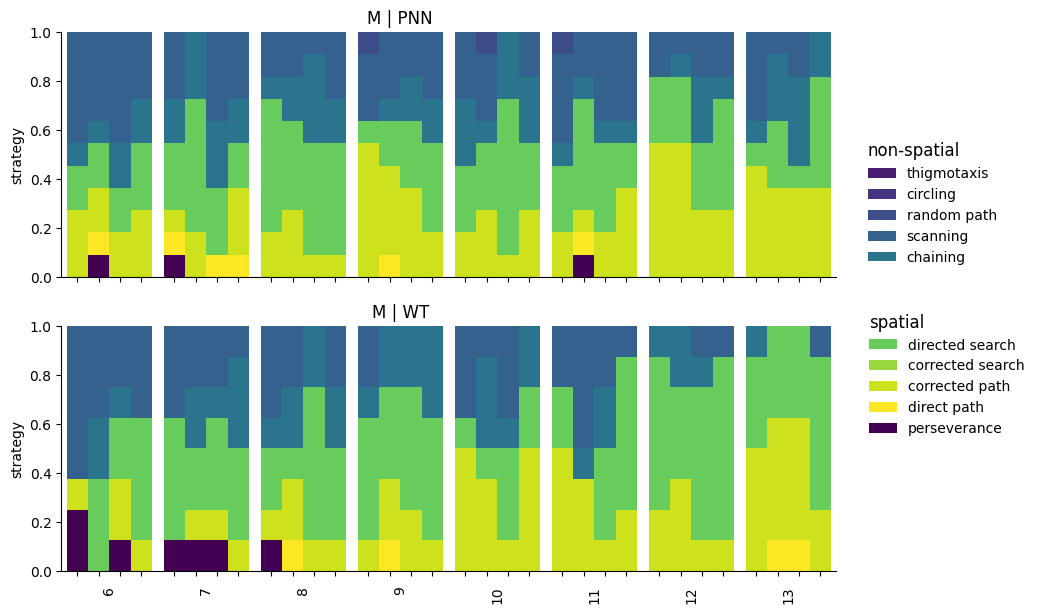

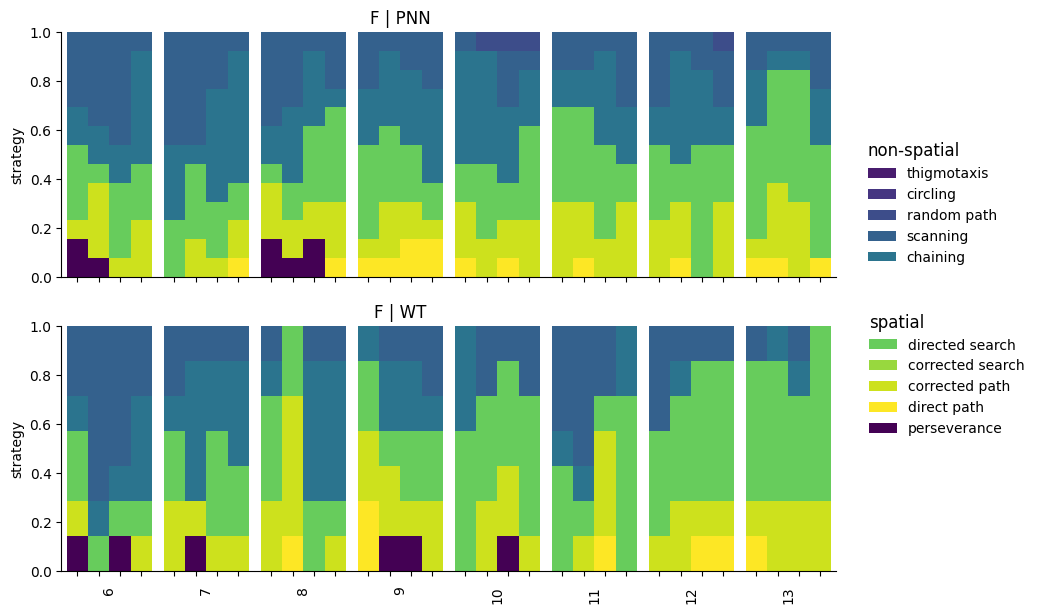

In [23]:

ls_pos = [
    [2., 0.0],
    [2.15, 0.5],
]
for i, sex_i in enumerate(['M', 'F']):

    fig, ax = plt.subplots(
        2,
        len(n),
        figsize=(10, 7),
        gridspec_kw={
            'width_ratios': width_ratios,
            'wspace': 0.01,
        }
    )
    
    for j, treat_j in enumerate(['PNN', 'WT']):
        for m, day_m in enumerate(sorted_groups.values()):
    
            df_jm = df_res[
                (df_res['sex']==sex_i) &
                (df_res['Geno']==treat_j) & 
                (df_res['exp_day']==day_m)
            ]
            df_jm = df_jm[[grp_var]+list(dct_strat.keys())[::-1]]
            plt_jm = df_jm.plot(
                kind='bar',
                x=grp_var,
                stacked=True,
                title=treat_j,
                ylabel='strategy',
                ax=ax[j,m],
                width=1,
                #color=list(dct_strat.values()),
                color=list(dct_strat.values())[::-1],
            )
            plt_jm.get_legend().remove()
            ax[j,m].set_ylim(0, 1)
    
            ax[j,m].spines.right.set_visible(False)
            ax[j,m].spines.top.set_visible(False)
            ax[j,m].set_xticklabels('')    
    
            if m!=0:
                ax[j,m].spines.left.set_visible(False)
                ax[j,m].set_yticks([])
                ax[j,m].set_ylabel('')          
            
            ax[j,m].set_title('')
            ax[j,m].set_xlabel('')
    
            if j==1:
                ax[j,m].set_xlabel(day_m, rotation=90)
            
            if m==3:
                #ax[j,m].set_title(sex_i + ' | ' +dct_treat[treat_j])
                ax[j,m].set_title(sex_i + ' | ' +treat_j)
        
        handles, labels = ax[j, -1].get_legend_handles_labels()
    
        for jj, (k, v) in enumerate(strat_group.items()):
            
            hndls_lbls_j = np.array(
                [[h, s] for h, s in zip(handles, labels) if s in v],
                dtype=object)
            hndls_j = hndls_lbls_j[:, 0]
            lbls_j = hndls_lbls_j[:, 1]
            
            if j==jj:
                leg_i = ax[j, -1].legend(
                    #hndls_j,
                    #lbls_j,
                    reversed(hndls_j),
                    reversed(lbls_j),
                    title=k,
                    alignment='left',
                    title_fontsize='large')
                #leg_i._legend_box.align = "left"
                sns.move_legend(
                    ax[j, -1],
                    "lower center",
                    bbox_to_anchor=ls_pos[j],
                    frameon=False, 
                )
               

In [24]:
strat_group.items()

dict_items([('non-spatial', ['chaining', 'scanning', 'random path', 'circling', 'thigmotaxis']), ('spatial', ['perseverance', 'direct path', 'corrected path', 'corrected search', 'directed search'])])

### Group into categories

In [25]:
def determine_strategy_category(row, strat_dict, col_name_strat='strategy_name'):
    strat_name = row[col_name_strat]
    strat_cat = [k for k, v in strat_dict.items() if strat_name in v][0]
    return strat_cat

In [26]:
# classify strategies according to the groups
df_train['strat_cat'] = df_train.apply(determine_strategy_category, axis=1, args=(strat_group_new, 'strategy_name'))
# convert to one how encoding
df_dummies = pd.get_dummies(df_train['strat_cat'], columns=['strat_cat'], prefix='is')
df_train = pd.concat([df_train, df_dummies], axis=1)


/tmp/ipykernel_193/1428111618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['strat_cat'] = df_train.apply(determine_strategy_category, axis=1, args=(strat_group_new, 'strategy_name'))


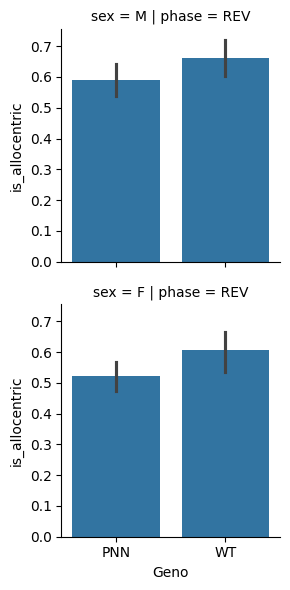

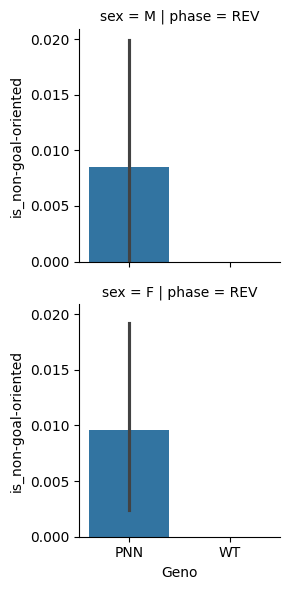

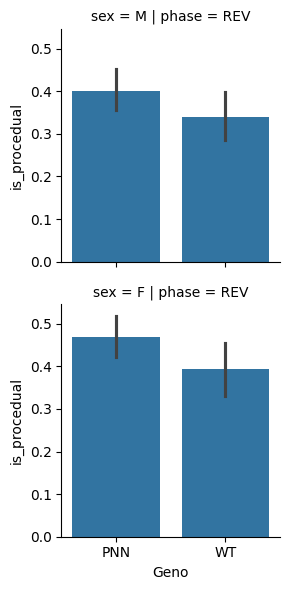

In [27]:
for cat_i in np.unique(df_train['strat_cat']):
    
    # Create a FacetGrid with 'phase' as the column variable and 'sex' as the row variable
    g = sns.FacetGrid(data=df_train, col="phase", row="sex")
    
    # Map a bar plot of trial duration to each grid item
    g.map(sns.barplot, "Geno", 'is_'+cat_i, order=['PNN', 'WT'])

## Compare first and last day of reversal training
For every animal, determine fraction of trials using spatial strategy at day 1 and day 8

In [128]:
strat_group = {
    'non-spatial':[
         'chaining',
         'scanning',
         'random path',
         'circling',
         'thigmotaxis'   
    ],
    'spatial': [
         'perseverance',
         'direct path',
         'corrected path',
         'corrected search',
         'directed search',
         ]
}

In [129]:
df_train['strat_cat_spatial'] = df_train.apply(determine_strategy_category, axis=1, args=(strat_group, 'strategy_name'))
df_train.loc[:, 'is_spatial'] = df_train.apply(lambda row: True if row['strat_cat_spatial'] == 'spatial' else False, axis=1)

In [130]:
grp_id_day = df_train.groupby(['animal_id', 'day', 'sex', 'Geno'])
# get fraction
frac_spatial = grp_id_day['is_spatial'].mean()
# convert to dataframe
df_frac_id_day_spatial = frac_spatial.reset_index()


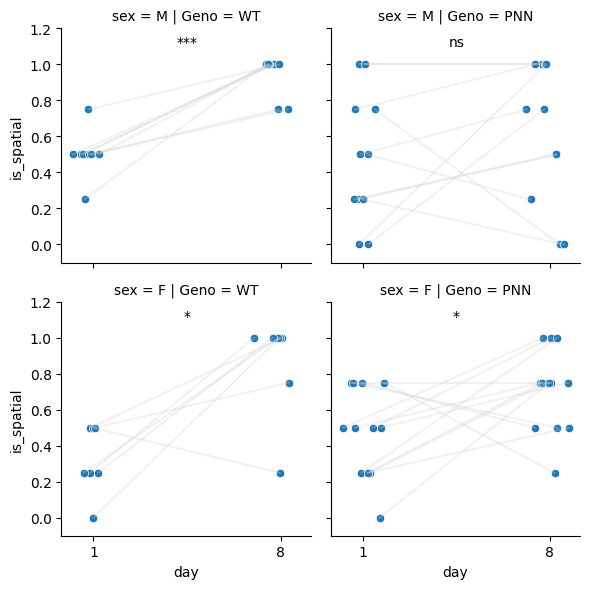

In [131]:
# Define a function to convert p-values to asterisks
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

# Calculate the p-values and asterisks for each group
grouped = df.groupby(['Geno', 'sex'])
pvalues = grouped.apply(lambda group: ttest_rel(group[group['day'] == 1]['is_spatial'], group[group['day'] == 8]['is_spatial']).pvalue)
asterisks = pvalues.apply(convert_pvalue_to_asterisks)
# Create a dictionary that maps ('Geno', 'sex') to asterisks
asterisks_dict = {group: asterisk for group, asterisk in zip(pvalues.index, asterisks)}

# Create a mapping from 'animal_id' to a unique shift value for each group
shift_values = np.linspace(-.5, .5, grouped['animal_id'].nunique().max())
for (geno, sex), group in grouped:
    animal_ids = group['animal_id'].unique()
    shift_mapping = dict(zip(animal_ids, shift_values[:len(animal_ids)]))
    df.loc[group.index, 'day_shifted'] = df.loc[group.index, 'day'] + df.loc[group.index, 'animal_id'].map(shift_mapping)

# Add a small jitter
df.loc[:, 'day_shifted'] = df['day_shifted'] + np.random.uniform(-0.5, 0.5, size=len(df))

# Create a FacetGrid object
g = sns.FacetGrid(df, col="Geno",  row="sex")

# Define a custom function to plot
def plot_lines(data, **kwargs):
    animal_ids = data['animal_id'].unique()
    for animal_id in animal_ids:
        animal_data = data[data['animal_id'] == animal_id]
        sns.lineplot(data=animal_data, x='day_shifted', y='is_spatial', color='lightgrey', alpha=0.3, legend=False)

# Map the custom lineplot to the FacetGrid
g.map_dataframe(plot_lines)

# Map the scatterplot to the FacetGrid
g.map_dataframe(sns.scatterplot, x="day_shifted", y="is_spatial")

# Create a list of tuples that represent the row and column indices of each group
indices = [(i, j) for i in range(len(df['sex'].unique())) for j in range(len(df['Geno'].unique()))]

# Add the asterisks to the plot
for i, row_name in enumerate(g.row_names):
    for j, col_name in enumerate(g.col_names):
        # Get the corresponding asterisk
        asterisk = asterisks_dict.get((col_name, row_name), '')

        # Add the asterisk to the subplot
        g.axes[i, j].text(4.5, 1.1, asterisk, ha='center')

# Limit xticks to 1 and 8
g.set(ylim=[-, 1.2])
g.set(xticks=[1, 8])
g.set_xlabels("day")

In [100]:
# Group the DataFrame by 'sex' and 'Geno'
grouped = df.groupby(['sex', 'Geno'])

# Perform the paired t-test for each group is a test for the null hypothesis that two related or repeated samples have identical average (expected) values
for (sex, geno), group in grouped:
    day1 = group[group['day'] == 1]['is_spatial']
    day8 = group[group['day'] == 8]['is_spatial']
    t_stat, p_val = ttest_rel(day1, day8)
    print(f"For sex = '{sex}', Geno = '{geno}':")
    print(f"  T-statistic: {t_stat}")
    print(f"  P-value: {p_val}")

For sex = 'F', Geno = 'PNN':
  T-statistic: -2.280350850198276
  P-value: 0.04165185454018319
For sex = 'F', Geno = 'WT':
  T-statistic: -3.3824071260127297
  P-value: 0.014813722759443312
For sex = 'M', Geno = 'PNN':
  T-statistic: -0.9439751632913288
  P-value: 0.3674302558285506
For sex = 'M', Geno = 'WT':
  T-statistic: -7.0
  P-value: 0.00021155485194587255


In [28]:
# First, ensure you have the rpy2 package installed
!pip install rpy2

# Load the rpy2 interface
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector

# Use the R interface to install the Matrix package
utils = importr('utils')
utils.chooseCRANmirror(ind=1)  # Select the first mirror in the list
utils.install_packages(StrVector(['Matrix']))

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


R[write to console]: Error: cannot connect to the system package manager



RRuntimeError: Error: cannot connect to the system package manager


In [ ]:
import pandas as pd
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter

# Convert Pandas DataFrame to R data frame using localconverter
pandas2ri.activate()
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_data = robjects.conversion.py2rpy(df_train)

# Import lme4 package in R
lme4 = importr('lme4')

# Define your model formula (with random intercepts)
formula = 'is_allocentric ~ grp_day_trial + Geno + sex + (1 | animal_id)'

# Fit the mixed-effects model using glmer
model = lme4.glmer(formula, data=r_data, family=robjects.r('binomial'))

# Access and print the model summary
print(robjects.r['summary'](model))

In [ ]:
r_data

In [ ]:
df_train_dummies = pd.get_dummies(df_train, columns=['strat_class'], drop_first=True)

In [ ]:
 lme4.glmer?


In [ ]:
df_train_dummies.iloc[0]

In [ ]:
 pd.get_dummies?